## Coordinate Fixes 
The data is downloaded on a rectangular grid, but the U.S. is not a perfect rectangle. To eliminate the data that are not from the United States, we use the Geocoordinate package that detects if a given coordinate is in the United States. Eliminating these coordiantes allow us to plot an almost perfect U.S. heat map. Note that the data used for training is not processed. 

In [2]:
import numpy as np 
import xarray as xr 
import cfgrib 
import pandas as pd 
import torch 
import torch.nn.functional as F
from utilities3 import *
import time 
from matplotlib import pyplot as plt
import reverse_geocoder as rg
import json
import pandas as pd
from shapely.geometry import Polygon, Point, MultiPolygon
from scipy.ndimage import zoom

**Import the geo coordinates packge**

In [2]:
data = json.load(open('.../gz_2010_us_040_00_20m (1).json'))
df= pd.DataFrame(data['features'])

In [3]:
df['Location'] = df['properties'].apply(lambda x: x['NAME'])
df['Type'] = df['geometry'].apply(lambda x: x['type'])
df['Coordinates'] = df['geometry'].apply(lambda x: x['coordinates'])

In [4]:
df_new = pd.DataFrame()

for idx, row in df.iterrows():

    if row['Type'] == 'MultiPolygon':
        list_of_polys = []
        df_row = row['Coordinates']
        for ll in df_row:
            list_of_polys.append(Polygon(ll[0]))
        poly = MultiPolygon(list_of_polys)

    elif row['Type'] == 'Polygon':
        df_row = row['Coordinates']
        poly = Polygon(df_row[0])

    else:
        poly = None

    row['Polygon'] = poly
    df_new = pd.concat([df_new, pd.DataFrame([row])], ignore_index=True)

In [5]:
df_selection = df_new.drop(columns=['type', 'properties', 'geometry','Coordinates'] )

In [6]:
#long x lat
point = Point(-80,43) #Example GPS location for somewhere in Florida
state = df_selection.apply(lambda row: row['Location'] if row['Polygon'].contains(point) else None, axis=1).dropna()
print(state)

Series([], dtype: object)


**Import the data to eliminate the coordiantes for plotting**

In [ ]:
gt= np.load('...4att_1yr/output/FNO.npy')
gt.shape 

In [ ]:
new= zoom(gt,8,order=5)
new.shape 

In [ ]:
#latitude, longitude: 840x1896, final after 

lat= np.arange(start=50,stop=24+0.03092, step=-0.03092)
long= np.arange(start=-124,stop=-65+0.03115, step=0.03115) 

*Eliminate coordinates*

In [ ]:
j=0
for lon in long: 
    i=0  
    for la in lat: 
        point= Point(lon, la)
        state = df_selection.apply(lambda row: row['Location'] if row['Polygon'].contains(point) else None, axis=1).dropna()
        if state.empty:
            new[i][j] = np.nan
        i+=1 
    print(f'i={i},j={j}')
    j+=1 


*Pad left and top so the map will look closer to the actual U.S. map*

In [ ]:
#after padding: 870 x 2006
nans=np.ones((30, 1896))* np.nan
new= np.vstack((nans,new))
nans= np.ones((110,870)) * np.nan
new= np.insert(new,0,nans,axis=1)


**Interpolation**
Geometric interpolation is used to increase the resolution of the graph

**SCIPY**

In [ ]:
def trig_inter_2d(u1, in_size, out_size):
    if u1.ndim == 2:
      fu1 = np.fft.rfft2(u1, norm = "ortho")
      fu1_recover = np.zeros((out_size, out_size//2 + 1), dtype=np.complex64)
      fu1_recover[:in_size//2, :in_size//2 + 1] = fu1[:in_size//2, :in_size//2 + 1]
      fu1_recover[-in_size//2:, :in_size//2 + 1] = fu1[-in_size//2:, :in_size//2 + 1]
      u1_recover = np.fft.irfft2(fu1_recover, norm = "ortho") * (out_size/in_size)
    else:
      n = u1.shape[0]
      fu1 = np.fft.rfft2(u1, norm = "ortho")
      fu1_recover = np.zeros((n, out_size, out_size//2 + 1), dtype=np.complex64)
      fu1_recover[:, :in_size//2, :in_size//2 + 1] = fu1[:, :in_size//2, :in_size//2 + 1]
      fu1_recover[:, -in_size//2:, :in_size//2 + 1] = fu1[:, -in_size//2:, :in_size//2 + 1]
      u1_recover = np.fft.irfft2(fu1_recover, norm = "ortho") * (out_size/in_size)
    return u1_recover

In [118]:
def trig_inter_2d_rect(u1, input1, input2, out1, out2):
    if u1.ndim == 2:
      fu1 = np.fft.rfft2(u1, norm = "ortho")
      fu1_recover = np.zeros((out1, out2//2+1), dtype=np.complex64)
      print(f"fu1_recover:{fu1_recover.shape}")
      fu1_recover[:input1//2+1, :input2//2+1 ] = fu1[:input1//2+1, :input2//2+1 ]
      fu1_recover[-input1//2:, :input2//2+1] = fu1[-input1//2:, :input2//2+1]
      print(f"{input1//2+1 + input1//2}")
      print(f"{input1//2}")
      u1_recover = np.fft.irfft2(fu1_recover, norm = "ortho") * (out1/input1) #same ratio of increase for both dimensions
    else:
      n = u1.shape[0]
      fu1 = np.fft.rfft2(u1, norm = "ortho")
      fu1_recover = np.zeros((n, out_size, out_size//2 + 1), dtype=np.complex64)
      fu1_recover[:, :in_size//2, :in_size//2 + 1] = fu1[:, :in_size//2, :in_size//2 + 1]
      fu1_recover[:, -in_size//2:, :in_size//2 + 1] = fu1[:, -in_size//2:, :in_size//2 + 1]
      u1_recover = np.fft.irfft2(fu1_recover, norm = "ortho") * (out_size/in_size)
    print(f'output size:{u1_recover.shape}')
    return u1_recover
  #return u1, fu1, fu1_recover, u1_recover

In [ ]:
def plot_images_and_spectra(u1, fu1, fu1_recover, u1_recover):
    # Compute the magnitude spectra
    spectrum_fu1 = np.abs(fu1)
    spectrum_fu1_recover = np.abs(fu1_recover)
    
    # Log-scale for better visualization
    spectrum_fu1_log = np.log(1 + spectrum_fu1)
    spectrum_fu1_recover_log = np.log(1 + spectrum_fu1_recover)
    
    # Plotting
    plt.figure(figsize=(14, 10))

    # Original Image and its Spectrum
    plt.subplot(2, 2, 1)
    plt.title("Original Image")
    plt.imshow(u1, cmap='gray', origin='lower')
    plt.colorbar()
    
    plt.subplot(2, 2, 2)
    plt.title("Original Spectrum")
    plt.imshow((spectrum_fu1_log), cmap='gray', origin='lower')
    plt.colorbar()
    
    # Resized Image and its Spectrum
    plt.subplot(2, 2, 3)
    plt.title("Resized Image")
    plt.imshow(u1_recover, cmap='gray', origin='lower')
    plt.colorbar()
    
    plt.subplot(2, 2, 4)
    plt.title("Resized Spectrum")
    plt.imshow((spectrum_fu1_recover_log), cmap='gray', origin='lower')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

# Sample input: non-square 2D array
in_shape = (4, 6)  # Input shape (rows, columns)
out_shape = (8, 12)  # Output shape (rows, columns)

# Create a test image with a pattern
u1 = np.zeros(in_shape)
u1[1:3, 2:4] = 1

# Resize the image
u1, fu1, fu1_recover, u1_recover = trig_inter_2d_rect(gt, 69,233, 138, 466)

# Plotting original and resized images along with their spectra
plot_images_and_spectra(u1, fu1, fu1_recover, u1_recover)

In [ ]:
new= trig_inter_2d_rect(gt, 69,233, 138, 466)

**After interpolation + coordinate fixes**

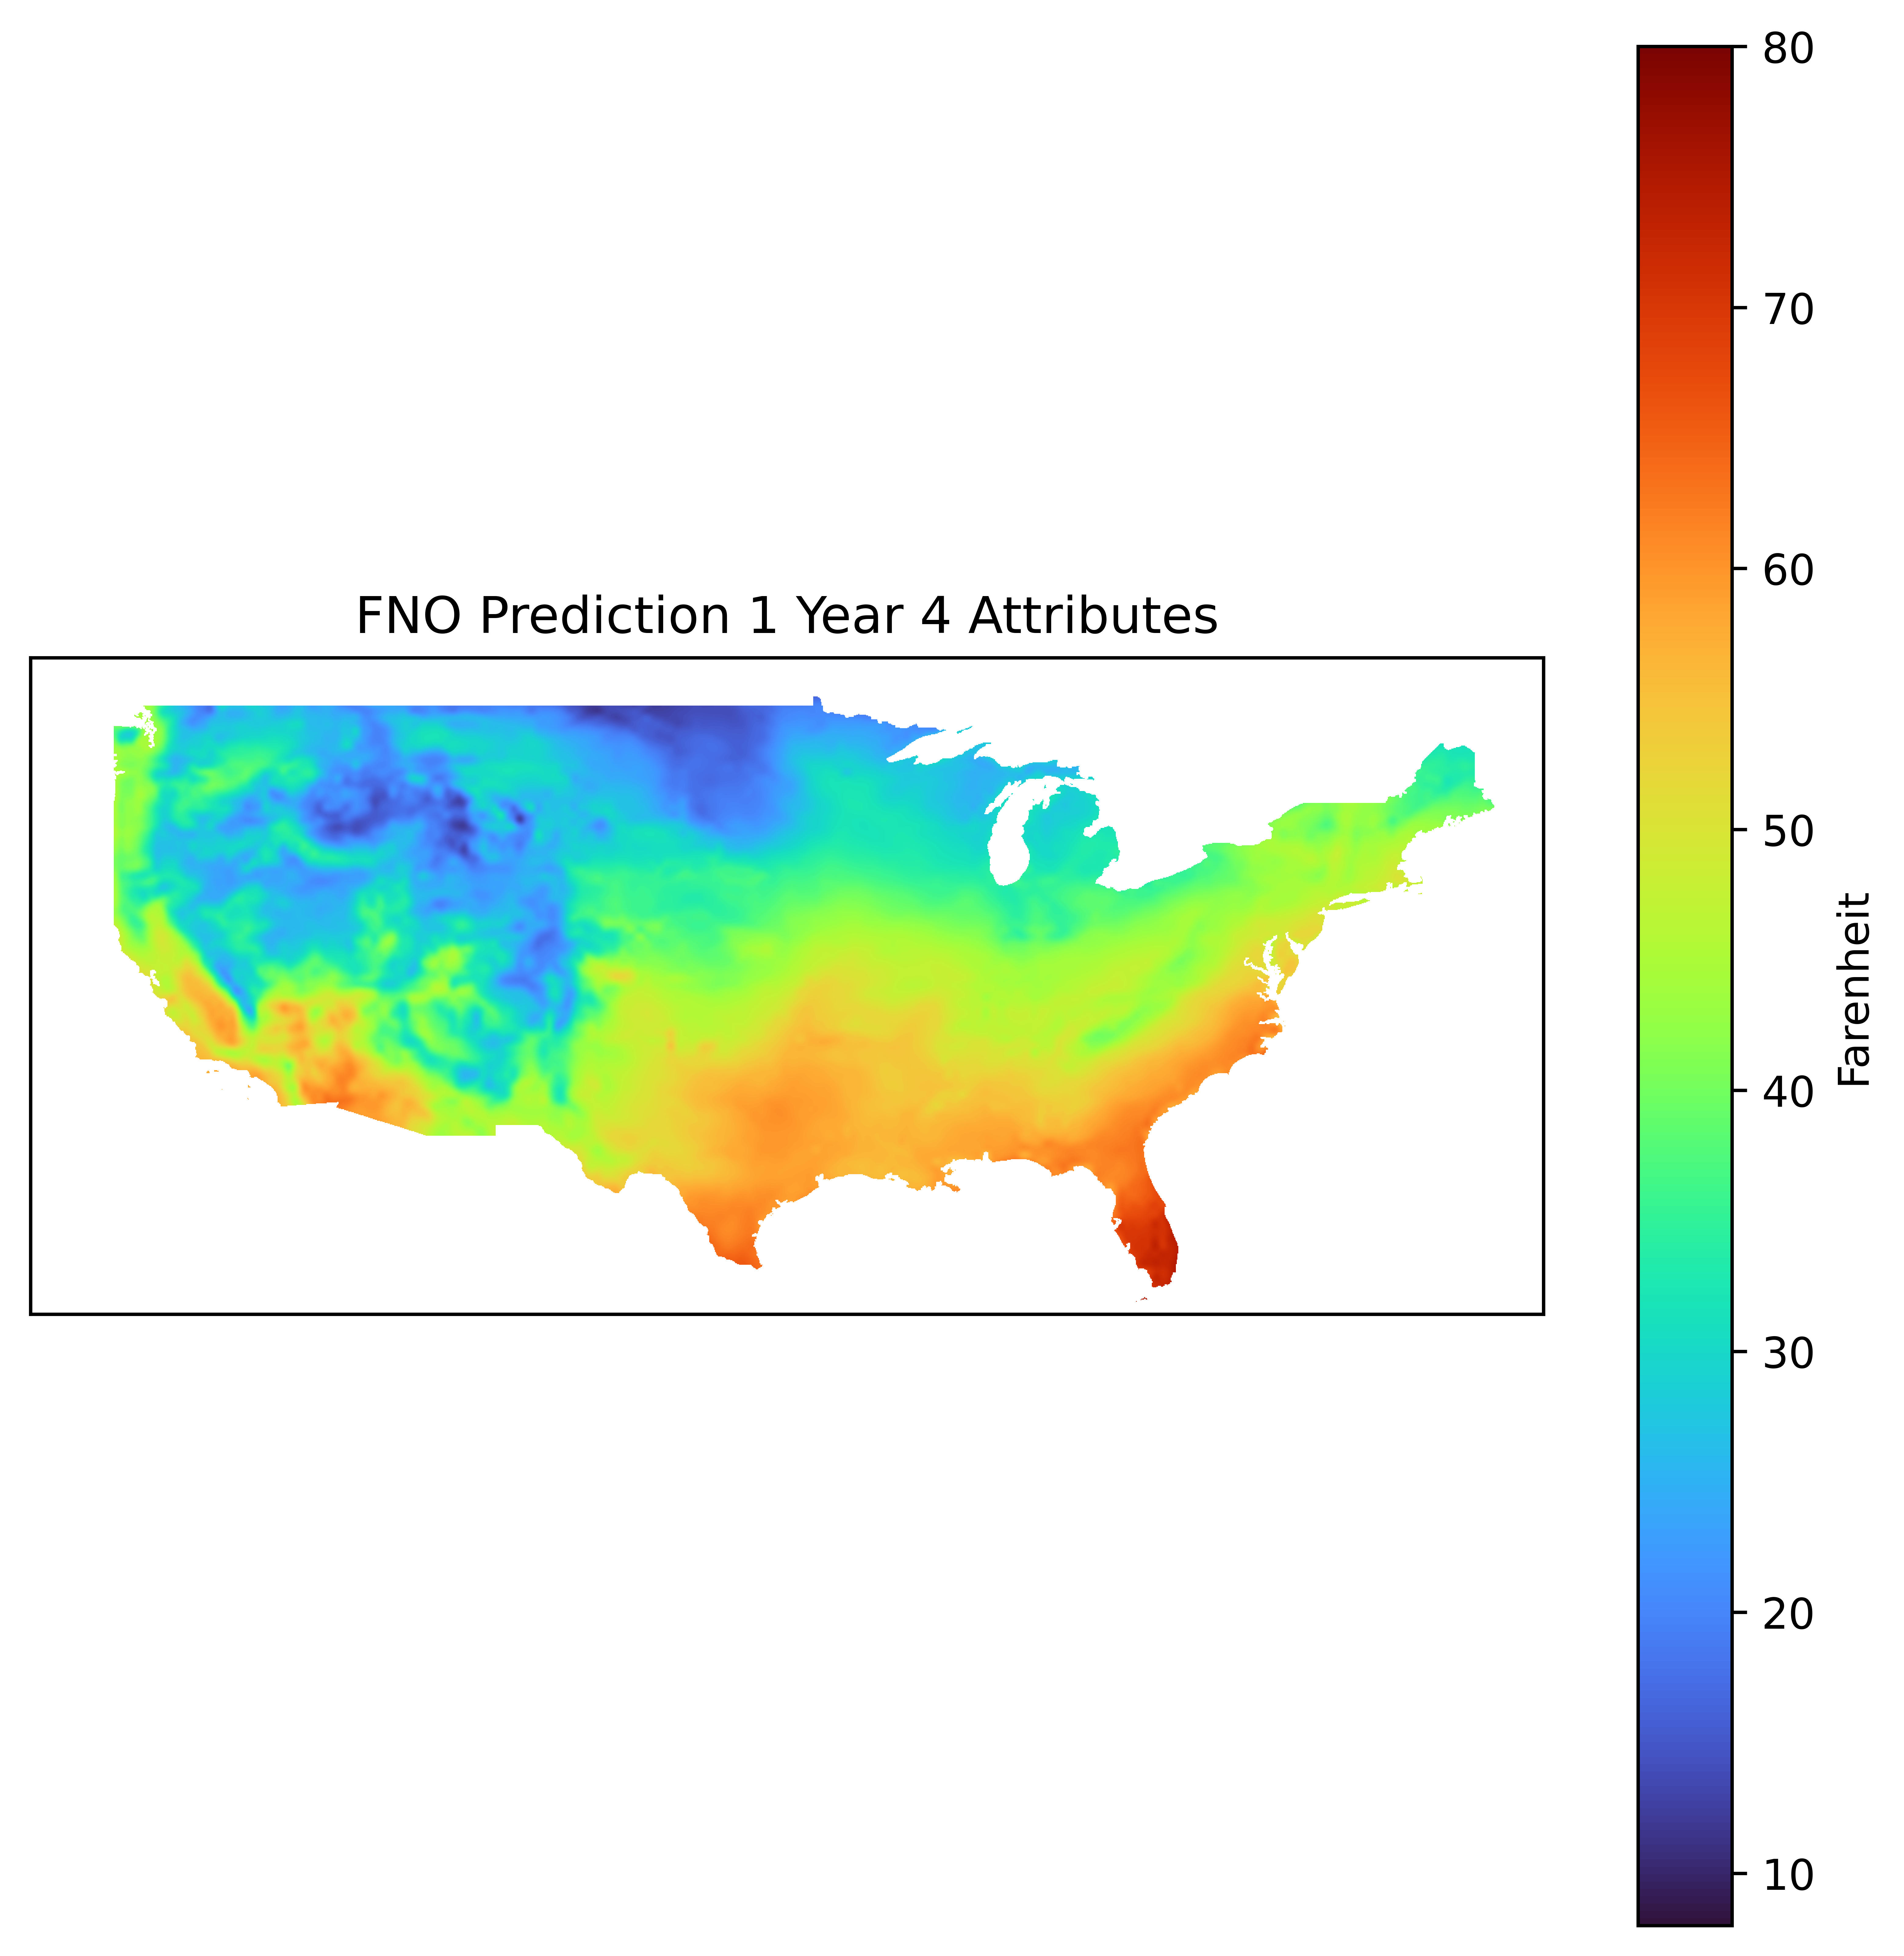

In [20]:
# 69 latitude points, 233 longitude points
#latitude: 48-31 
# long: -124 -> -66
fig,ax= plt.subplots() 
plt.rcParams['figure.dpi']= 1000

#ax.set_ylabel('latitude')
#ax.set_xlabel('longitude')
ax.set_title('FNO Prediction 1 Year 4 Attributes')
im= ax.imshow(new, cmap='turbo', vmin=8, vmax=80)
fig.colorbar(im, label='Farenheit')
#lat = [48,45,42,39,36,33]
#long= [-114,-104,-94,-84,-74]
#plt.yticks(np.arange(0,64, step=12.1), lat )
#plt.xticks(np.arange(0,233, step=47), long)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
fig.set_size_inches(8,8)
plt.savefig('/home/liuxiang/new_data/plotdata/4attFNO.png')
plt.show()


**Before interpolation + coordiante fixes**

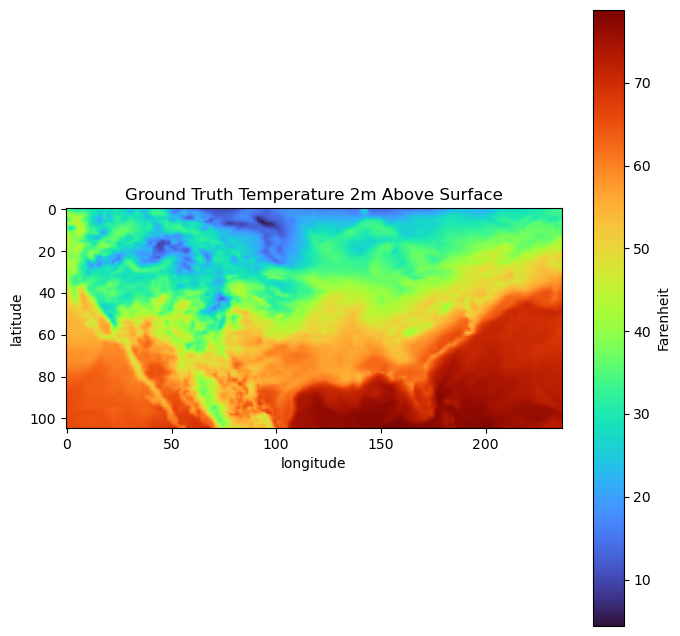

In [55]:
# 69 latitude points, 233 longitude points
#latitude: 48-31 
# long: -124 -> -66
fig,ax= plt.subplots() 
plt.rcParams['figure.dpi']= 1000

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
ax.set_title('Ground Truth Temperature 2m Above Surface')
im= ax.imshow(gt, cmap='turbo')
fig.colorbar(im, label='Farenheit')
lat = [48,45,42,39,36,33]
long= [-114,-104,-94,-84,-74]
#lt.yticks(np.arange(0,64, step=12.1), lat )
#plt.xticks(np.arange(0,233, step=47), long)
fig.set_size_inches(8,8)
plt.show()